# _IMDB Explore Data_

> In this project I will present a basic guide for exploratory data analysis using Python Language, SQL Language and SQLite Database. I will use real publicly available data about movies on <a href="https://www.imdb.com/interfaces/">IMDB</a>. 

> When applying Exploratory Data Analysis I will answer these 10 questions: 

> - 1- What Are the Most Common Movie Categories on IMDB?
> - 2- What is the number of titles by genre?
> - 3- What is the Median Rating of Films by Gender?
> - 4- What is the Median Rating of Films in relation to the year of release?
> - 5- What is the number of films rated by genre in relation to the year of release?
> - 6- What is the Longest Time Movie? Calculate Percentiles.
> - 7- What is the Relationship Between Duration and Gender?
> - 8- What is the number of films produced by country?
> - 9- What are the Top 10 Best Movies?
> - 10- What Are the Top 10 Worst Movies? 

### _Installing and Loading Packages_

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Python version used in this notebook:', python_version())

In [ ]:
# Installing imdb package
!pip install -q imdb-sqlite

In [ ]:
# Installing pycountry package
# https://pypi.org/project/pycountry/
!pip install -q pycountry

In [1]:
# Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
from IPython.core.display import HTML
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

### _Loading Data_

>First we have to download the ratings data from imdb 

In [ ]:
%%time
!imdb-sqlite

In [2]:
# Connecting in the database
conn = sqlite3.connect("imdb.db")

In [3]:
# Extracting table list
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)
type(tables)

pandas.core.frame.DataFrame

In [4]:
# Show results
#We have 6 tables in this database:
tables

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [5]:
# Convert dataframe to list
tables = tables["Table_Name"].values.tolist()

In [6]:
# Let's extract the schema of each table 
for table in tables:
    query = "PRAGMA TABLE_INFO({})".format(table)
    result = pd.read_sql_query(query, conn)
    print("Schema of: {}".format(table))
    display(result)
    print("-"*100)
    print("\n")

Schema of: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Schema of: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Schema of: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Schema of: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Schema of: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Schema of: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




> Description of each table: 
> * ratings: User ratings.
> * episodes: The film can be: A television series, a documentary, etc.. organized into seasons and episodes
> * crew: Team that participated in the production of the film.
> * akas: Filme region and language. 
> * titles: Movie names.
> * people: Actors and actresses who participated in the film.


In [7]:
#Showing how many records there are in the titles table
queryCount = '''SELECT COUNT(*) as TOTAL FROM titles'''
resCount = pd.read_sql_query(queryCount, conn)
display(resCount)

,TOTAL
0,8533544


## Now let's start exploring the data

#### _1- What Are the Most Common Movie Categories on IMDB?_

In [8]:
#Creating SQL query
query1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [9]:
#Executing SQL query
res1 = pd.read_sql_query(query1, conn)

In [10]:
#Showing result
#display(HTML(res.to_html())) #Show all dataframe
display(res1)

,type,COUNT
0,movie,597005
1,short,847120
2,tvEpisode,6364611
3,tvMiniSeries,41156
4,tvMovie,134077
5,tvPilot,2
6,tvSeries,218094
7,tvShort,10421
8,tvSpecial,35303
9,video,255797


In [11]:
#Calculating the percentage for each type
res1['percent'] = (res1['COUNT'] / res1['COUNT'].sum()) * 100

In [12]:
res1['percent'] = res1['percent'].apply(lambda x: round(x, 2)) #Round 2 decimal

In [13]:
#res1.drop(columns='colum_name', inplace=True) #Delete a column

In [14]:
display(res1)

,type,COUNT,percent
0,movie,597005,7.00
1,short,847120,9.93
2,tvEpisode,6364611,74.58
3,tvMiniSeries,41156,0.48
4,tvMovie,134077,1.57
5,tvPilot,2,0.00
6,tvSeries,218094,2.56
7,tvShort,10421,0.12
8,tvSpecial,35303,0.41
9,video,255797,3.00


In [15]:
#Let's create a graph with only 4 categories, because the human brain doesn't process much more than that simultaneously.
#The three categories with the most titles. 

#Create an empty dictionary
others = {}

#Filter the percentage in 5% and add the total
others['COUNT'] = res1[res1['percent'] < 5]['COUNT'].sum()

#Record the percentage
others['percent'] = res1[res1['percent'] < 5]['percent'].sum()

#adjust the name
others['type'] = 'others'

In [16]:
#Show others
others

{'COUNT': 724808, 'percent': 8.489999999999998, 'type': 'others'}

In [17]:
#Filter the dataframe where percent > 5 
res1 = res1[res1['percent'] >= 5]

#Appendo with dataframe from other categories
res1 = res1.append(others, ignore_index = True)

#Order the result
res1 = res1.sort_values(by = 'COUNT', ascending = False)

#Show
res1.head()

,type,COUNT,percent
2,tvEpisode,6364611,74.58
1,short,847120,9.93
3,others,724808,8.49
0,movie,597005,7.00


In [18]:
# Adjust the labels
labels = [str(res1['type'][i])+' '+'['+str(round(res1['percent'][i],2)) +'%'+']' for i in res1.index]

In [19]:
labels

['tvEpisode [74.58%]', 'short [9.93%]', 'others [8.49%]', 'movie [7.0%]']

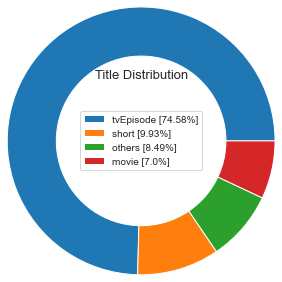

In [20]:
# Plot

# Color map
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.tab10(np.arange(100))

# Create the figure
f = plt.figure(figsize=(2, 3))

# Pie Plot configs
plt.pie(res1['COUNT'], radius = 3, colors = cs, wedgeprops = dict(width = 1.1))
plt.legend(labels = labels, loc = 'center', prop = {'size':10})
plt.title("Title Distribution", loc = 'Center', fontdict = {'fontsize':13,'fontweight':20})
plt.show()

#### _2- What is the number of titles by genre?_

Let's calculate the number of movies by genre and show the result as a percentage.

In [21]:
#Show all types from titles
queryType = '''SELECT DISTINCT type FROM titles'''
resType = pd.read_sql_query(queryType, conn)
display(resType)

,type
0,movie
1,short
2,tvEpisode
3,tvMiniSeries
4,tvMovie
5,tvPilot
6,tvSeries
7,tvShort
8,tvSpecial
9,video


In [22]:
#Creating SQL query
query2 = '''SELECT genres, COUNT(*) AS COUNT FROM titles WHERE type='movie' GROUP BY genres'''
#Execute SQL query
res2 = pd.read_sql_query(query2, conn)
#order by desc
res2 = res2.sort_values(by='COUNT', ascending=False)
# Converting strings to lower case
res2['genres'] = res2['genres'].str.lower().values

In [23]:
display(res2)

,genres,COUNT
1062,drama,110460
949,documentary,84161
1450,\n,71190
704,comedy,42845
1313,horror,14521
...,...,...
1207,"family,musical,sport",1
1206,"family,musical,sci-fi",1
492,"animation,comedy,mystery",1
1202,"family,music,sport",1


In [24]:
# Removing NA (Missing values)
temp = res2['genres'].dropna()

In [25]:
temp

1062                       drama
949                  documentary
1450                          \n
704                       comedy
1313                      horror
                  ...           
1207        family,musical,sport
1206       family,musical,sci-fi
492     animation,comedy,mystery
1202          family,music,sport
7           action,adult,fantasy
Name: genres, Length: 1451, dtype: object

In [26]:
# Let's create a vector using regular expression to filter the strings

# https://docs.python.org/3.8/library/re.html
pattern = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = pattern, analyzer = 'word').fit(temp)

In [27]:
# Applies vectorization to dataset without NA values
bag_genders = vetor.transform(temp)

In [28]:
# Return single genres
single_gender = vetor.get_feature_names()

In [29]:
# Create the genre dataframe
genders = pd.DataFrame(bag_genders.todense(), columns = single_gender, index = temp.index)

In [30]:
genders

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
1062,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
949,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1206,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
492,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1202,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [31]:
# Show
genders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 1062 to 7
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  n            1451 non-null   int64
 19  news         1451 non-null   int64
 20  reality-

In [32]:
# Drop column n
genders = genders.drop(columns = 'n', axis = 0)

In [39]:
# Calculates the percentage
genders_percent = 100 * pd.Series(genders.sum()).sort_values(ascending = False) / genders.shape[0]

In [40]:
# Visualiza
genders_percent.head(10)

drama          18.263267
comedy         16.815989
documentary    15.920055
adventure      14.886285
action         14.334941
romance        13.370090
crime          13.094418
mystery        12.405238
fantasy        12.267402
thriller       12.198484
dtype: float64

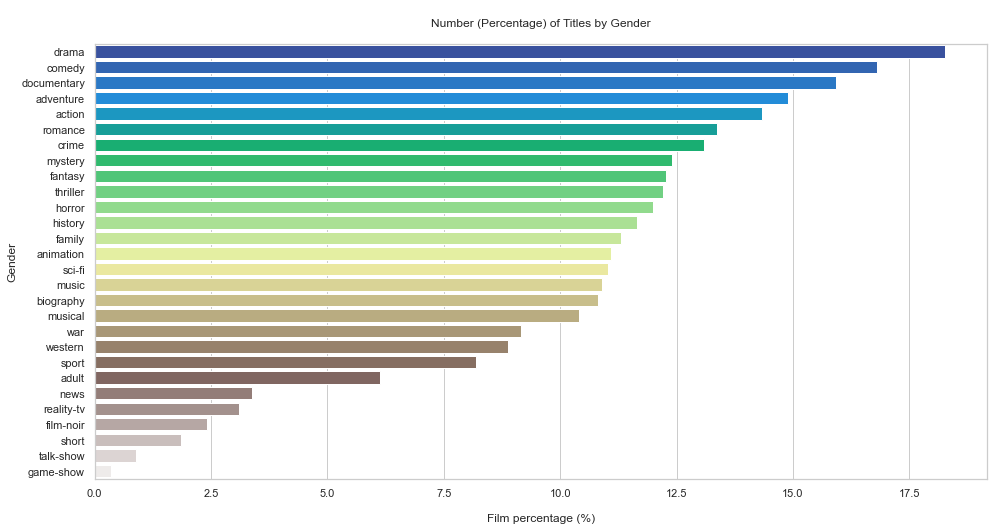

In [41]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = genders_percent.values, y = genders_percent.index, orient = "h", palette = "terrain")
plt.ylabel('Gender')             
plt.xlabel("\nFilm percentage (%)")
plt.title('\nNumber (Percentage) of Titles by Gender\n')
plt.show()

#### _3- What is the Median Rating of Films by Gender?_

In [42]:
query3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
        '''

In [43]:
res3 = pd.read_sql_query(query3, conn)

In [44]:
display(res3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
272370,3.5,"Action,Adventure,Thriller"
272371,5.8,Thriller
272372,6.4,"Drama,History"
272373,3.8,"Adventure,History,War"


In [45]:
# Let's create a function to return the genres 
def return_genres(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vector = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    single_genres =  vector.get_feature_names()
    single_genres = [genre for genre in single_genres if len(genre) > 1]
    return single_genres

In [46]:
# Apply the function
single_genres = return_genres(res3)

In [47]:
single_genres

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [50]:
# Create empty lists
genres_count = []
genres_median = []
genres_mean = []

In [51]:
# Loop
for item in single_genres:
    
    # Returns the count of films per gender
    query01 = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    res01 = pd.read_sql_query(query01, conn)
    genres_count.append(res01.values[0][0])
  
     # Returns the rating of filmes per gender
    query02 = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    res02 = pd.read_sql_query(query02, conn)
    genres_median.append(np.median(res02['rating']))
    genres_mean.append(np.mean(res02['rating']))

In [54]:
# Preparing the final dataframe
df_gender_ratings = pd.DataFrame()
df_gender_ratings['genres'] = single_genres
df_gender_ratings['count'] = genres_count
df_gender_ratings['median'] = genres_median
df_gender_ratings['mean'] = genres_mean

In [56]:
df_gender_ratings.drop(index=18, inplace=True)

In [57]:
df_gender_ratings

,genres,count,median,mean
0,action,28256,5.80,5.700173
1,adult,4198,5.80,5.777108
2,adventure,17216,6.00,5.880065
3,animation,4783,6.40,6.215639
4,biography,8209,7.00,6.954233
5,comedy,67517,6.00,5.904575
6,crime,23255,6.10,5.983057
7,documentary,40234,7.30,7.213568
8,drama,120743,6.40,6.239823
9,family,10569,6.30,6.221213


In [61]:
# Sorting values
df_gender_ratings.sort_values(by = 'median', ascending = False, inplace=True)

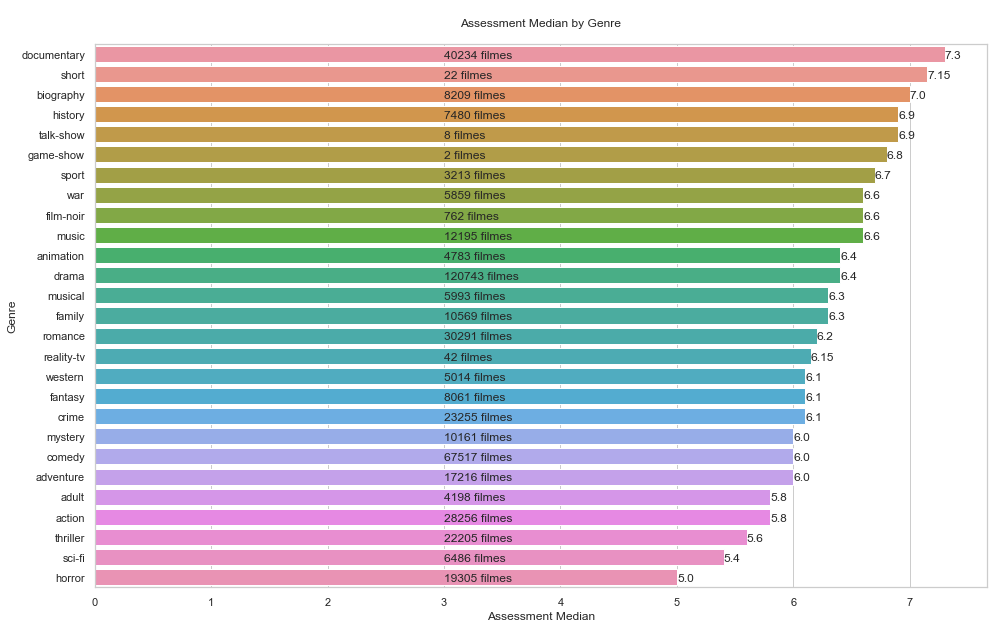

In [74]:
# Plot

# Figure
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_gender_ratings['genres'], x = df_gender_ratings['median'], orient = "h")

# Textos do gráfico
for i in range(len(df_gender_ratings.index)):
    
    plt.text(3.0, 
             i + 0.2, 
             str(df_gender_ratings['count'][df_gender_ratings.index[i]]) + " filmes")
    
    plt.text(df_gender_ratings['median'][df_gender_ratings.index[i]],
             i + 0.2,
             round(df_gender_ratings["median"][df_gender_ratings.index[i]],2))

plt.ylabel('Genre')             
plt.xlabel('Assessment Median')
plt.title('\nAssessment Median by Genre\n')
plt.show()

#### _4- What is the Median Rating of Films in relation to the year of release?_

In [76]:
query4 = '''
            SELECT rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
        '''

res4 = pd.read_sql_query(query4, conn)

In [78]:
display(res4)

,rating,premiered
0,4.5,1905
1,6.1,1906
2,5.2,1907
3,4.5,1907
4,3.8,1908
...,...,...
272370,3.5,2020
272371,5.8,2020
272372,6.4,2020
272373,3.8,2019


In [81]:
# We calculate the median over time (years)
ratings = []
for year in set(res4['premiered']):
    ratings.append(np.median(res4[res4['premiered'] == year]['rating']))

In [86]:
type(ratings)

list

In [87]:
ratings[1:10]

[4.5, 3.8, 5.85, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [91]:
# Years list
years = list(set(res4['premiered']))

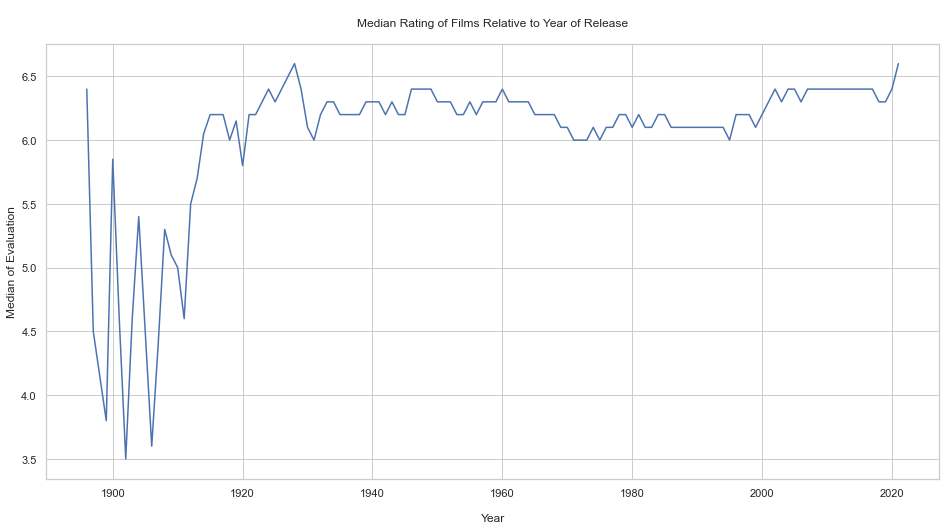

In [92]:
#Plot
plt.figure(figsize = (16,8))
plt.plot(years, ratings)
plt.xlabel('\nYear')
plt.ylabel('Median of Evaluation')
plt.title('\nMedian Rating of Films Relative to Year of Release\n')
plt.show()

#### _5- What is the number of films rated by genre in relation to the year of release?_

In [100]:
# Consulta SQL
query5 = '''SELECT genres FROM titles GROUP BY genres''' 
# Resultado
res5 = pd.read_sql_query(query5, conn)
# show
display(res5)

,genres
0,Action
1,"Action,Adult"
2,"Action,Adult,Adventure"
3,"Action,Adult,Animation"
4,"Action,Adult,Comedy"
...,...
2295,"Thriller,Western"
2296,War
2297,"War,Western"
2298,Western


In [101]:
# Apply the function
single_genres = return_genres(res5)

In [103]:
# Let's count
genre_count = []
for item in single_genres:
    query = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    res = pd.read_sql_query(query, conn)
    genre_count.append(res['COUNT'].values[0])

In [104]:
# Prepare the dataframe
df_genre_count = pd.DataFrame()
df_genre_count['genre'] = single_genres
df_genre_count['count'] = genre_count

In [ ]:
'''
# Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values
'''

In [110]:
df_genre_count.sort_values(by='count', inplace=True, ascending=False)

In [114]:
top5 = df_genre_count[0:5]['genre'].values

In [115]:
top5

array(['drama', 'documentary', 'comedy', 'action', 'romance'],
      dtype=object)

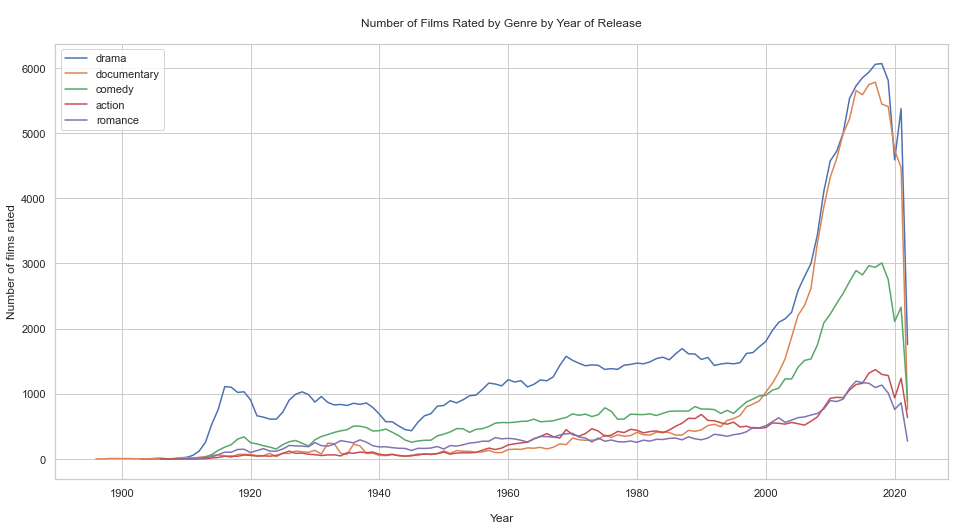

In [117]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top5:
    query = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    res = pd.read_sql_query(query, conn)
    plt.plot(res['Year'], res['Number_of_movies'])

plt.xlabel('\nYear')
plt.ylabel('Number of films rated')
plt.title('\nNumber of Films Rated by Genre by Year of Release\n')
plt.legend(labels = top5)
plt.show()

#### _6- What is the Longest Time Movie? Calculate Percentiles._

In [118]:
# Consulta SQL
query6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 
# Resultado
res6 = pd.read_sql_query(query6, conn)

display(res6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
375359,123
375360,57
375361,100
375362,116


In [120]:
# Loop for calculating percentiles
for i in range(101): 
    val = i
    perc = round(np.percentile(res6['Runtime'].values, val), 2)
    print('{} runtime percentile is: {}'.format(val, perc))

0 runtime percentile is: 1.0
1 runtime percentile is: 45.0
2 runtime percentile is: 48.0
3 runtime percentile is: 50.0
4 runtime percentile is: 50.0
5 runtime percentile is: 52.0
6 runtime percentile is: 52.0
7 runtime percentile is: 54.0
8 runtime percentile is: 55.0
9 runtime percentile is: 56.0
10 runtime percentile is: 58.0
11 runtime percentile is: 59.0
12 runtime percentile is: 60.0
13 runtime percentile is: 60.0
14 runtime percentile is: 60.0
15 runtime percentile is: 62.0
16 runtime percentile is: 63.0
17 runtime percentile is: 65.0
18 runtime percentile is: 66.0
19 runtime percentile is: 68.0
20 runtime percentile is: 69.0
21 runtime percentile is: 70.0
22 runtime percentile is: 71.0
23 runtime percentile is: 72.0
24 runtime percentile is: 73.0
25 runtime percentile is: 74.0
26 runtime percentile is: 75.0
27 runtime percentile is: 75.0
28 runtime percentile is: 76.0
29 runtime percentile is: 77.0
30 runtime percentile is: 78.0
31 runtime percentile is: 79.0
32 runtime percenti

In [121]:
# Redoing the query and returning the movie with longer duration
query6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

res6 = pd.read_sql_query(query6, conn)

display(res6)

,Runtime,primary_title
0,51420,Logistics


>'Logistics' is the longest film in history (to date), at 857 hours (51420 minutes). Directed by Daniel Andersson and Erika Magnusson, the film follows the entire lifecycle of a pedometer (step tracking device) in reverse chronological order.

#### _7- What is the Relationship Between Duration and Gender?_

In [122]:
# Query SQL
query7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

# Result
res7 = pd.read_sql_query(query7, conn)

# Apply the function to return single genres
single_genres = return_genres(res7)

# Show
display(single_genres)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [123]:
# Calculate duration by genre
genre_runtime = []
for item in single_genres:
    query = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    res = pd.read_sql_query(query, conn)
    genre_runtime.append(np.median(res['Runtime']))
    
# Preparing the dataframe
df_genre_runtime = pd.DataFrame()
df_genre_runtime['genre'] = single_genres
df_genre_runtime['runtime'] = genre_runtime

# Remove index 18 (news)
df_genre_runtime = df_genre_runtime.drop(index = 18)

# Sorting data
df_genre_runtime = df_genre_runtime.sort_values(by = 'runtime', ascending = False)

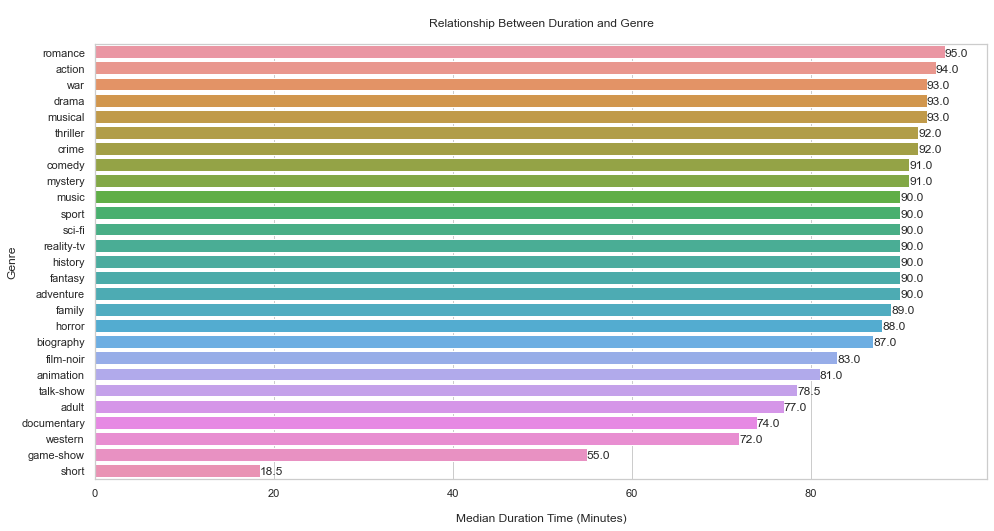

In [124]:
# Plot

# Figure size
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genre_runtime.genre, x = df_genre_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genre_runtime.index)):
    plt.text(df_genre_runtime.runtime[df_genre_runtime.index[i]],
             i + 0.25,
             round(df_genre_runtime["runtime"][df_genre_runtime.index[i]], 2))

plt.ylabel('Genre')             
plt.xlabel('\nMedian Duration Time (Minutes)')
plt.title('\nRelationship Between Duration and Genre\n')
plt.show()

#### _8- What is the number of films produced by country?_

In [130]:
# Query SQL
query8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            '''
res8 = pd.read_sql_query(query8, conn)

res8.sort_values(by='Number_of_movies', inplace=True, ascending=False)
display(res8)

,region,Number_of_movies
205,US,303876
70,GB,155937
101,JP,89909
226,XWW,87598
68,FR,83128
...,...,...
215,WS,1
147,NC,1
135,MP,1
105,KI,1


In [131]:
res8.shape

(234, 2)

In [134]:
# Aux lists
country_names = []
count = []

# Loop to get country according to region
for i in range(res8.shape[0]):
    try:
        reg = res8['region'].values[i]
        country_names.append(pycountry.countries.get(alpha_2 = reg).name)
        count.append(res8['Number_of_movies'].values[i])
    except: 
        continue

In [135]:
# Preparing the dataframe
df_films_country = pd.DataFrame()
df_films_country['country'] = country_names
df_films_country['Movie_Count'] = count

In [137]:
display(df_films_country.head(10))

,country,Movie_Count
0,United States,303876
1,United Kingdom,155937
2,Japan,89909
3,France,83128
4,India,77416
5,Canada,74018
6,Germany,68518
7,Italy,64528
8,Spain,64048
9,Brazil,63949


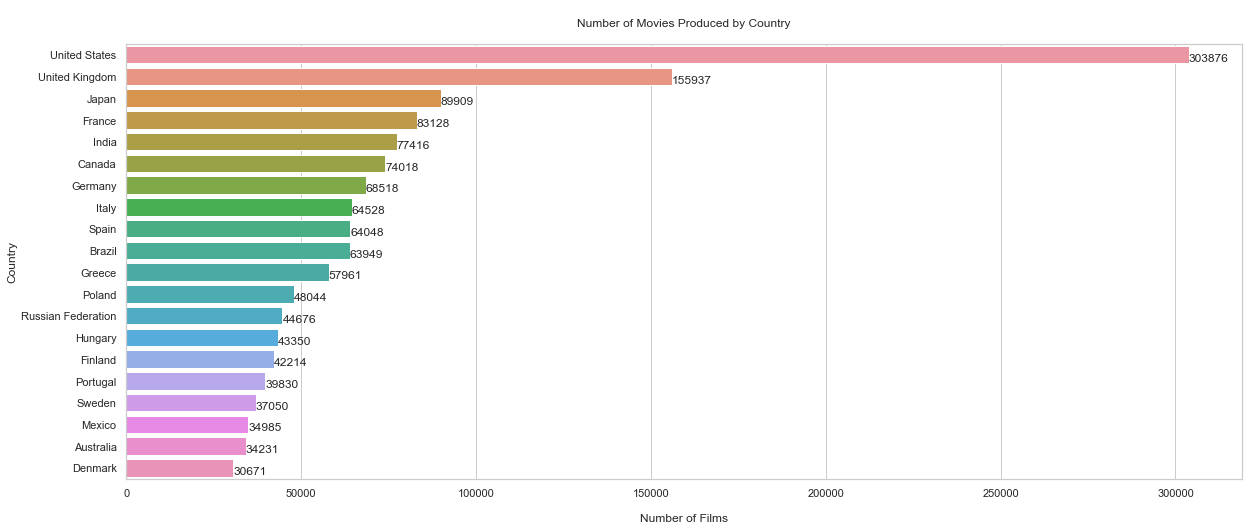

In [138]:
# Plot

# Figure
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_films_country[:20].country, x = df_films_country[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_films_country.Movie_Count[df_films_country.index[i]]-1,
             i + 0.30,
             round(df_films_country["Movie_Count"][df_films_country.index[i]],2))

plt.ylabel('Country')             
plt.xlabel('\nNumber of Films')
plt.title('\nNumber of Movies Produced by Country\n')
plt.show()

#### _9- What are the Top 10 Best Movies?_

In [139]:
# Consulta SQL
query9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 
res9 = pd.read_sql_query(query9, conn)

#show
display(res9)

,Movie_Name,genres,rating
0,Jai Bhim,"Crime,Drama",9.4
1,The Shawshank Redemption,Drama,9.3
2,The Chaos Class,"Comedy,Drama",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,Spider-Man: No Way Home,"Action,Adventure,Fantasy",9.1
6,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
7,Mirror Game,"Crime,Mystery,Thriller",9.1
8,12 Angry Men,"Crime,Drama",9.0
9,The Godfather: Part II,"Crime,Drama",9.0


#### _10- What Are the Top 10 Worst Movies?_

In [141]:
# Consulta SQL
query10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10          
            ''' 
res10 = pd.read_sql_query(query10, conn)

#show
display(res10)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Reis,"Biography,Drama",1.4
4,The Cost of Deception,"Crime,Drama,History",1.5
5,Justin Bieber: Never Say Never,"Documentary,Music",1.6
6,Manos: The Hands of Fate,Horror,1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Radhe,"Action,Crime,Thriller",1.9
